# Описание данных

*Признаки*
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

*Целевой признак*
- Price — цена (евро)


# План работы
- Изучить файл с данными.
- Проверить данные на пропуски, дубликаты, корреляцию.
- Визуализировать данные.
- Провести предобработку данных
- Разбить данные на две выборки в соотношении 75:25 : обучающая, тестовая.
- Обучить разные модели.
- Проанализировать скорость работы и качество моделей

## Подготовка данных

Импортируем библиотеки и прочтём файл

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from catboost import CatBoostRegressor


import warnings 
warnings.filterwarnings('ignore')
import time

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Check

In [3]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [4]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])

In [5]:
check(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB

Кол-во дубликатов - 4

Кол-во пропусков:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear  

**Промежуточные выводы:** Имеются дубли и пропуски. В одном из столбцов кол-во пропусков доходит до 20%. Изменим тип столбцов object на category. В столбце NotRepaired изменим на числовой. Также имеется большое кол-во нулевых значений в интересующих нас столбцах 'Price', 'Power'.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


### Корреляция

In [7]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


**Промежуточные выводы:** Имеется очень слабая корреляция между столбцами Price и Power.

### Графики

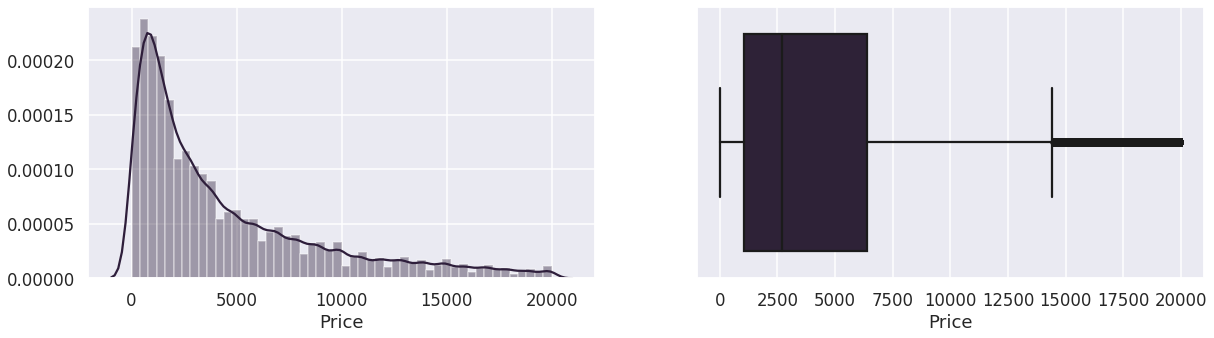

In [8]:
charts(data,'Price', '')

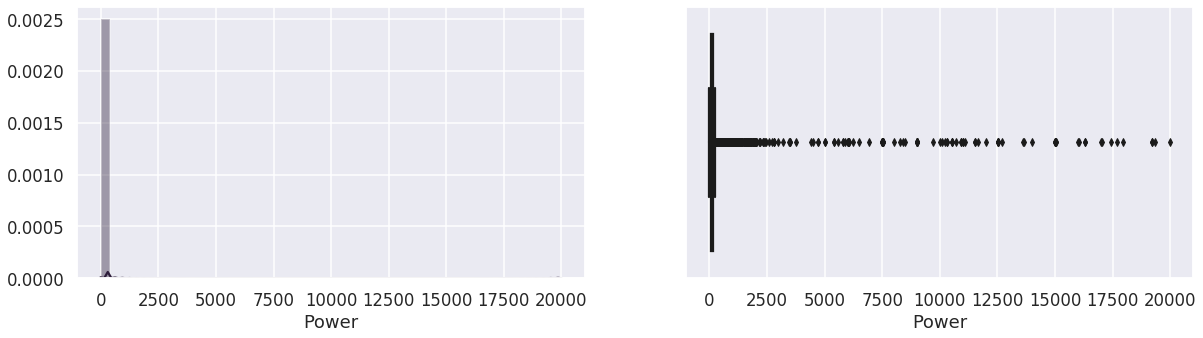

In [9]:
charts(data, 'Power', '')

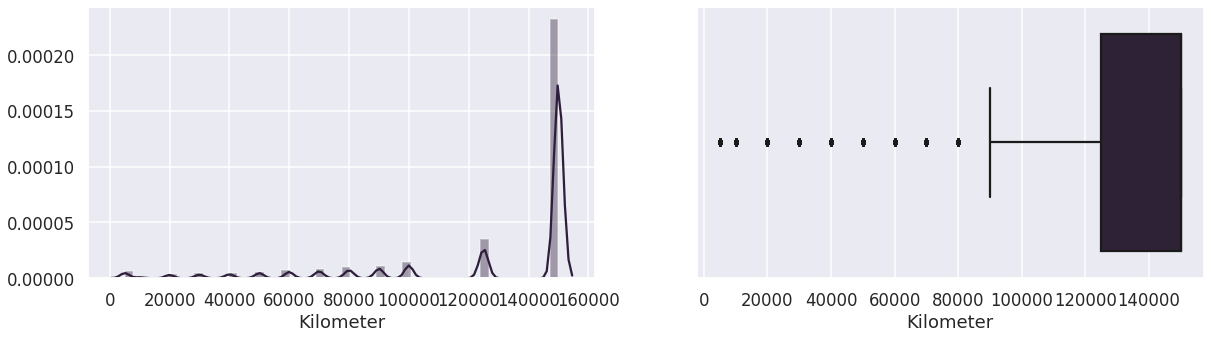

In [10]:
charts(data, 'Kilometer', '')

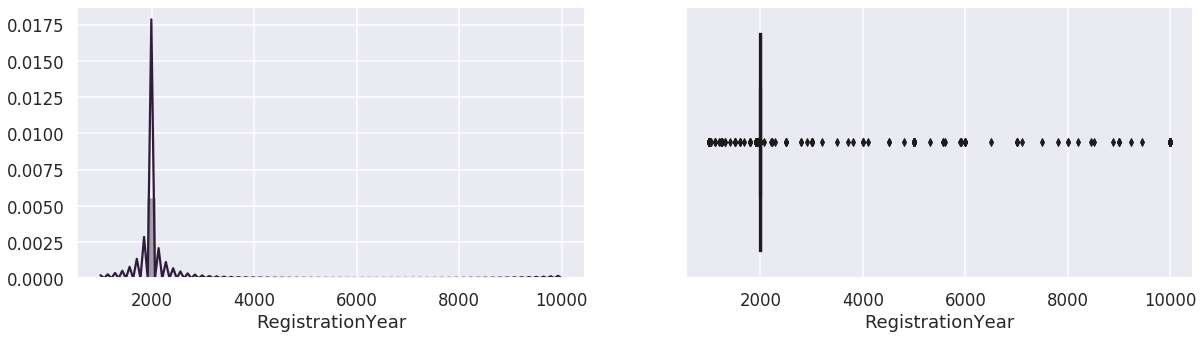

In [11]:
charts(data, 'RegistrationYear', '')

**Промежуточные выводы:** На рассмотренных графиках видим, что имеются выбросы и нулевые значения. В дальнейшим избавимся от них.

### Предобработка данных

-  Для дальнейшего исследования удалим дубликаты и не нужные столбцы:'DateCrawled','DateCreated','NumberOfPictures','PostalCode', 'Model','LastSeen'.
- Изменим столбец NotRepaired на численный yes - 1, no - 0.
- Избавимся от нулевых значений и выбросов в Price и Power.
- Изменим типы данных
- Разделим данные на обучающую и тестовую выборки

#### Drop

In [12]:
#drop duplicates
data.drop_duplicates(inplace=True)

#drop columns
data = data.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode', 'Model','LastSeen'],axis=1)

In [14]:
data['NotRepaired'] = data['NotRepaired'].map({'yes':1, 'no':0})

In [15]:
data = data[(data['RegistrationYear'] >= 1929) 
     & (data['RegistrationYear'] <= 2021)
    & (data['Price'] > 50) & (data['Price'] <= 14000)
    & (data['Power'] > 20) & (data['Power'] <= 400)]

In [16]:
data = data.dropna(axis=0, subset = ['Gearbox', 'VehicleType', 'FuelType'])

In [17]:
data['NotRepaired'].fillna('0',inplace=True)

In [19]:
#замена типов данных
data['NotRepaired'] = data['NotRepaired'].astype('int')
data[['VehicleType', 
      'Gearbox','FuelType','Brand']] = data[['VehicleType', 
                                                            'Gearbox',
                                             'FuelType','Brand']].astype('category')

#### Split

In [20]:
data_orig = data.copy()
data_ohe = pd.get_dummies(data, drop_first = True)

In [21]:
#original
features = data_orig.drop(['Price'], axis=1)
target = data_orig['Price']

#ohe
ohe_features = data_ohe.drop(['Price'], axis=1)
ohe_target = data_ohe['Price']

In [22]:
#ohe
train_ohe_features, test_ohe_features, train_ohe_target, test_ohe_target = train_test_split(ohe_features, ohe_target , test_size = 0.25, random_state=12345)

#original
train_features, test_features, train_target, test_target = train_test_split = train_test_split(features, target, test_size = 0.25, random_state=12345)

print('Размер train выборки - {}'.format(train_ohe_features.shape[0]))
print('Размер test выборки - {}'.format(test_ohe_features.shape[0]))
print('Размер train orig выборки - {}'.format(train_features.shape[0]))

Размер train выборки - 188926
Размер test выборки - 62976
Размер train orig выборки - 188926


**Промежуточные выводы:** Очистили и подготовили данные для дальнейшего исследования.

## Обучение моделей

### Линейная регрессия, Случайный лес регрессия, Древо решений регрессия

In [23]:
model_1 = LinearRegression()
model_2 = RandomForestRegressor(random_state=12345)
model_3 = DecisionTreeRegressor(random_state=12345)

param_LR = {'fit_intercept':[True,False], 'copy_X':[True, False], 
                  'normalize':[True,False]}
param_RF = {'n_estimators':[5,100],
             'max_depth':[1,10], 'min_samples_split': [2, 3]}
param_DT= {'max_depth':[1,20], 'splitter':('best','random'), 'min_samples_split':np.arange(2,10)}

In [24]:
LR = GridSearchCV(model_1 ,param_grid = param_LR)
RF = GridSearchCV(model_2,param_grid = param_RF)
DT = GridSearchCV(model_3,param_grid = param_DT)

In [25]:
%%time
#Линейная регрессия
start_1 = time.time()
LR.fit(train_ohe_features, train_ohe_target)
end_1 = time.time()
fit_LR = end_1 - start_1

start_2 = time.time()
prediction_LR = LR.predict(test_ohe_features)
end_2 = time.time()
pred_LR = end_2 - start_2

rmse_LR = (mean_squared_error(test_ohe_target, prediction_LR) ** 0.5)
r2_LR = r2_score(test_ohe_target, prediction_LR)

print('\n========================================================')
print('Линейная регрессия')
print('========================================================')
print('RMSE:', round(rmse_LR, 4))
print('R2:', round(r2_LR, 4))
print('Время обучения:', round(fit_LR,4), 'vs', 'Время предсказания', round(pred_LR,4))
print()
print('Наилучшие гиперпараметры:',LR.best_params_)
print()


Линейная регрессия
RMSE: 2141.9561
R2: 0.6282
Время обучения: 63.9495 vs Время предсказания 0.196

Наилучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'normalize': True}

CPU times: user 40.4 s, sys: 23.7 s, total: 1min 4s
Wall time: 1min 4s


In [26]:
%%time
#Cлучаный лес регрессия
start_1 = time.time()
RF.fit(train_ohe_features, train_ohe_target)
end_1 = time.time()
fit_RF = end_1 - start_1

start_2 = time.time()
prediction_RF = RF.predict(test_ohe_features)
end_2 = time.time()
pred_RF = end_2 - start_2

rmse_RF = (mean_squared_error(test_ohe_target, prediction_RF) ** 0.5)
r2_RF = r2_score(test_ohe_target, prediction_RF)

print('\n========================================================')
print('Случаный лес регрессия')
print('========================================================')
print('RMSE:', round(rmse_RF, 4))
print('R2:', round(r2_RF, 4))
print('Время обучения:', round(fit_RF,4), 'vs', 'Время предсказания', round(pred_RF,4))
print()
print('Наилучшие гиперпараметры:',RF.best_params_)
print()


Случаный лес регрессия
RMSE: 1510.6823
R2: 0.8151
Время обучения: 439.0393 vs Время предсказания 0.5399

Наилучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}

CPU times: user 7min 17s, sys: 0 ns, total: 7min 17s
Wall time: 7min 19s


In [27]:
%%time
#Древо решений регрессия
start_1 = time.time()
DT.fit(train_ohe_features, train_ohe_target)
end_1 = time.time()
fit_DT = end_1 - start_1

start_2 = time.time()
prediction_DT = DT.predict(test_ohe_features)
end_2 = time.time()
pred_DT = end_2 - start_2

rmse_DT = (mean_squared_error(test_ohe_target, prediction_DT) ** 0.5)
r2_DT = r2_score(test_ohe_target, prediction_DT)

print("\n========================================================")
print("Древо решений регрессия" )
print("========================================================")
print('RMSE:', round(rmse_DT, 4))
print('R2:', round(r2_DT, 4))
print('Время обучения:', round(fit_DT,4), 'vs', 'Время предсказания', round(pred_DT,4))
print()
print('Наилучшие гиперпараметры:',DT.best_params_)
print()


Древо решений регрессия
RMSE: 1469.8165
R2: 0.8249
Время обучения: 63.5162 vs Время предсказания 0.0299

Наилучшие гиперпараметры: {'max_depth': 20, 'min_samples_split': 9, 'splitter': 'random'}

CPU times: user 1min 3s, sys: 113 ms, total: 1min 3s
Wall time: 1min 3s


### CatBoost

In [28]:
%%time
cat = CatBoostRegressor(loss_function='RMSE', depth=5, n_estimators = 1000, learning_rate = 0.1)
start_1 = time.time()
cat.fit(train_features, train_target,eval_set=[(test_features, test_target),], verbose = 100, cat_features = ['VehicleType','Gearbox','FuelType','Brand'])
end_1 = time.time()
fit_cat = end_1 - start_1

start_2 = time.time()
prediction_cat = cat.predict(test_features)
end_2 = time.time()
pred_cat = end_2 - start_2

rmse_cat = (mean_squared_error(test_target, prediction_cat) ** 0.5)
   
print("\n========================================================")
print("CatBoost" )
print("========================================================")
print('RMSE:', round(rmse_cat, 4))
print('Время обучения:', round(fit_cat,4), 'vs', 'Время предсказания:', round(pred_cat,4))
print()

0:	learn: 3300.3426647	test: 3294.0946058	best: 3294.0946058 (0)	total: 342ms	remaining: 5m 41s
100:	learn: 1457.4197426	test: 1460.5897236	best: 1460.5897236 (100)	total: 29.2s	remaining: 4m 20s
200:	learn: 1403.3574666	test: 1407.1557382	best: 1407.1557382 (200)	total: 57.3s	remaining: 3m 47s
300:	learn: 1375.5715343	test: 1381.5951999	best: 1381.5951999 (300)	total: 1m 25s	remaining: 3m 17s
400:	learn: 1355.7825182	test: 1364.8435824	best: 1364.8435824 (400)	total: 1m 52s	remaining: 2m 47s
500:	learn: 1342.2324418	test: 1354.1008924	best: 1354.1008924 (500)	total: 2m 20s	remaining: 2m 19s
600:	learn: 1332.0393318	test: 1346.3722295	best: 1346.3722295 (600)	total: 2m 46s	remaining: 1m 50s
700:	learn: 1324.4765699	test: 1341.4061805	best: 1341.4061805 (700)	total: 3m 13s	remaining: 1m 22s
800:	learn: 1318.4362844	test: 1337.6374482	best: 1337.6374482 (800)	total: 3m 39s	remaining: 54.6s
900:	learn: 1312.5255053	test: 1334.3281171	best: 1334.2791584 (899)	total: 4m 7s	remaining: 27.2s


### LightGBM

In [29]:
%%time
lgbm = lgb.LGBMRegressor(depth=5, n_estimators=1000, learning_rate = 0.1)

start_1 = time.time()
lgbm.fit(train_features, train_target, verbose = 100, eval_set=[(test_features, test_target),], eval_metric='rmse')
end_1 = time.time()
fit_lgbm = end_1 - start_1

start_2 = time.time()
prediction_lgbm = lgbm.predict(test_features)
end_2 = time.time()
pred_lgbm = end_2 - start_2

rmse_lgbm = (mean_squared_error(test_target, prediction_lgbm) ** 0.5)

print("\n========================================================")
print("LGBMRegressor" )
print("========================================================")
print('RMSE:', round(rmse_lgbm, 4))
print()
print('Время обучения:', round(fit_lgbm,4), 'vs', 'Время предсказания:', round(pred_lgbm,4))
#print()

[100]	valid_0's rmse: 1351.97	valid_0's l2: 1.82783e+06
[200]	valid_0's rmse: 1321.29	valid_0's l2: 1.7458e+06
[300]	valid_0's rmse: 1303.11	valid_0's l2: 1.69811e+06
[400]	valid_0's rmse: 1294.2	valid_0's l2: 1.67496e+06
[500]	valid_0's rmse: 1287.32	valid_0's l2: 1.6572e+06
[600]	valid_0's rmse: 1282.68	valid_0's l2: 1.64526e+06
[700]	valid_0's rmse: 1277.89	valid_0's l2: 1.63301e+06
[800]	valid_0's rmse: 1273.81	valid_0's l2: 1.6226e+06
[900]	valid_0's rmse: 1271.38	valid_0's l2: 1.6164e+06
[1000]	valid_0's rmse: 1269.6	valid_0's l2: 1.61187e+06

LGBMRegressor
RMSE: 1269.5964

Время обучения: 86.5874 vs Время предсказания: 6.6318
CPU times: user 1min 31s, sys: 702 ms, total: 1min 32s
Wall time: 1min 33s


## Анализ моделей

По итогам исследования удалось установить, что важным признаками для предсказания цены, являются RegistrationYear  и Power.

В ходе исследования обучили 5 моделей и для каждой попробовали различные гипепараметры. Расположим результаты полученных показателей от наилучшего к худшему. 

**Базовые модели | RMSE:**
- Древо решений регрессия: 1469.8
- Случайный лес регрессия: 1510.6
- Линейная регрессия: 2141.9

**Скорость обучения:**
- Линейная регрессия: 63.9
- Древо решений регрессия: 63.5
- Случайный лес регрессия: 439.0

**Скорость предсказания:**
- Древо решений регрессия: 0.029
- Линейная регрессия: 0.196
- Случайный лес регрессия: 0.539

**Модели с градиентным бустингом | гиперпараметры (depth = 5, iterations = 1000, learn_rate = 0.1) | RMSE:**
- LightGBM: 1269.5
- CatBoost: 1331.3

**Скорость обучения:**
- LightGBM: 86.5
- CatBoost: 278.2

**Скорость предсказания:**
- CatBoost: 0.26
- LightGBM: 6.63

Итак, среди простых моделей можно выделить алгоритм Древо решений регрессия. А что касается CatBoost и LightGBM, оба алгоритма показали неплохие результаты RMSE с небольшой разницей в пользу LightGBM. Также стоит отметить, что LightGBM показал хорошие результаты по скорости обучения.
По итогом исследования из полученных результатов можно выделить следующие решения для заказчика:
- Если важна точность и неважна скорость предсказания - LGBMRegressor
- Если важна скорость предсказания — CatBoostRegressor